In [1]:
#Logistic Regression and other Classifiers using F1 Data Set - Deepak Verma (2019)
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
from datetime import date
from datetime import datetime as dt
%matplotlib inline
sns.set()

In [2]:
#Import Data from
results4 = pd.read_csv('results_full4(+weather).csv')
results4.head()

,Unnamed: 0,resultId,raceId,driverId,constructorId,grid,positionText,positionOrder,points,laps,...,country,constructorRef,nationality_y,position_quali,stop,lap,milliseconds,name,weather,SC Laps
0,0,20780,841,1,1,2,2,2,18.0,58,...,Australia,mclaren,British,2.0,1,16,23227,Australian Grand Prix,Dry,NaN
1,1,20780,841,1,1,2,2,2,18.0,58,...,Australia,mclaren,British,2.0,2,36,23199,Australian Grand Prix,Dry,NaN
2,2,20784,841,18,1,4,6,6,8.0,58,...,Australia,mclaren,British,4.0,1,17,16867,Australian Grand Prix,Dry,NaN
3,3,20784,841,18,1,4,6,6,8.0,58,...,Australia,mclaren,British,4.0,2,19,23303,Australian Grand Prix,Dry,NaN
4,4,20784,841,18,1,4,6,6,8.0,58,...,Australia,mclaren,British,4.0,3,37,22681,Australian Grand Prix,Dry,NaN


In [3]:
# remove duplicate results of each pit stop, keep only last pit stop number for each race.
results5 = results4[results4['stop'] == results4.groupby('resultId')['stop'].transform(max)]
results5.reset_index(drop=True, inplace=True)

In [4]:
# Fill NaN on 'SC Laps' with Integer 0
results5['SC Laps'] = results5['SC Laps'].fillna(0).astype(np.int32)

C:\Users\dverm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
#Removing colunmns not needed:
# ResultId & RaceId are indices, driverId and ConstructorId duplicates of respective Ref values, nationality, round, year, etc.
results6 = results5.drop(columns=['Unnamed: 0','resultId', 'raceId', 'driverId', 'constructorId','positionText',
                                     'status', 'nationality_x', 'round','name_x','year', 'location',
                                     'country', 'nationality_y', 'name', 'positionOrder'])

In [6]:
# Calculate Age of Driver at time of Race
results6['dob'] = pd.to_datetime(results6['dob'])
results6['date'] = pd.to_datetime(results6['date'])
results6['age']= (((results6['date'] - results6['dob'])).dt.days/365).astype(np.int64)
results6 = results6.drop(columns=['date','dob'])

In [7]:
# Drop FastestLapTimes with an \N value and convert to seconds
results7 = results6.drop(results6[results6.fastestLapTime == '\\N'].index)
results7['fastestLapTime'] = (pd.to_datetime(results7['fastestLapTime'], format="%M:%S.%f"))
results7['fastestLapTime'] = (results7['fastestLapTime'].dt.minute*60+results7['fastestLapTime'].dt.second+results7['fastestLapTime'].dt.microsecond/1000000).astype(np.float64)

In [8]:
# Convert points finishes (positions 1-10) to P and non-points (positions > 10) as N, remove points column
results7['Finish']=np.where(results7['points']> 0.0, 'P', 'N')
results8 = results7.drop(columns=['points'])
results8.head()

,grid,laps,fastestLapTime,fastestLapSpeed,driverRef,circuitRef,constructorRef,position_quali,stop,lap,milliseconds,weather,SC Laps,age,Finish
0,2,58,90.3,211.382,hamilton,albert_park,mclaren,2.0,2,36,23199,Dry,0,26,P
1,4,58,89.9,212.396,button,albert_park,mclaren,4.0,3,37,22681,Dry,0,31,P
2,17,48,91.4,208.861,barrichello,albert_park,williams,17.0,4,40,26309,Dry,0,38,N
3,18,57,92.4,206.661,heidfeld,albert_park,renault,18.0,2,30,25098,Dry,0,33,N
4,6,58,90.1,211.969,petrov,albert_park,renault,6.0,2,36,25683,Dry,0,26,P


In [9]:
results8.dtypes

grid                 int64
laps                 int64
fastestLapTime     float64
fastestLapSpeed     object
driverRef           object
circuitRef          object
constructorRef      object
position_quali     float64
stop                 int64
lap                  int64
milliseconds         int64
weather             object
SC Laps              int32
age                  int64
Finish              object
dtype: object

In [10]:
# Convert DataTypes to categorical variables.
results8['fastestLapSpeed'] = results8['fastestLapSpeed'].astype(np.float64)
results8['circuitRef'] = results8['circuitRef'].astype('category')
results8['constructorRef'] = results8['constructorRef'].astype('category')
results8['constructorRef'] = results8['constructorRef'].astype('category')
results8['position_quali'] = results8['position_quali'].fillna(99).astype(np.int32)
results8['milliseconds'] = (results8['milliseconds']/1000).astype(np.float64)
results8['weather'] = results8['weather'].astype('category')
results8.dtypes

grid                  int64
laps                  int64
fastestLapTime      float64
fastestLapSpeed     float64
driverRef            object
circuitRef         category
constructorRef     category
position_quali        int32
stop                  int64
lap                   int64
milliseconds        float64
weather            category
SC Laps               int32
age                   int64
Finish               object
dtype: object

In [11]:
# #Create a dataframe for input into Logistic Regression  & Rename Columns to something more meaningful
results_logr = results8.reset_index(drop=True)
results_logr.columns = ['GridStart', 'TotalLaps', 'FastestLapTime', 'FastestLapSpeed', 'Driver', 'Circuit', 'Constructor', 'QualifyPos', 'NumPitStops', 
                    'LastPitStopLap', 'PitStopTime', 'Weather', 'SaftetyCarLaps', 'DriverAge', 'PointsFinish']
results_logr.shape

(2738, 15)

In [12]:
results_logr['PointsFinish'].value_counts()

N    1389
P    1349
Name: PointsFinish, dtype: int64

In [13]:
# Ignoring Driver, focus on COnstructor
results_logr_dummy1 = pd.get_dummies(results_logr, columns = ['Circuit', 'Constructor', 'Weather'])

In [14]:
results_logr_dummy1.head()

,GridStart,TotalLaps,FastestLapTime,FastestLapSpeed,Driver,QualifyPos,NumPitStops,LastPitStopLap,PitStopTime,SaftetyCarLaps,...,Constructor_mercedes,Constructor_red_bull,Constructor_renault,Constructor_sauber,Constructor_toro_rosso,Constructor_virgin,Constructor_williams,Weather_Dry,Weather_Varied,Weather_Wet
0,2,58,90.3,211.382,hamilton,2,2,36,23.199,0,...,0,0,0,0,0,0,0,1,0,0
1,4,58,89.9,212.396,button,4,3,37,22.681,0,...,0,0,0,0,0,0,0,1,0,0
2,17,48,91.4,208.861,barrichello,17,4,40,26.309,0,...,0,0,0,0,0,0,1,1,0,0
3,18,57,92.4,206.661,heidfeld,18,2,30,25.098,0,...,0,0,1,0,0,0,0,1,0,0
4,6,58,90.1,211.969,petrov,6,2,36,25.683,0,...,0,0,1,0,0,0,0,1,0,0


In [15]:
features = list(results_logr_dummy1)
features.remove('Driver')
features.remove('PointsFinish')
X = results_logr_dummy1[features]
y = results_logr_dummy1['PointsFinish']

In [16]:
features

['GridStart',
 'TotalLaps',
 'FastestLapTime',
 'FastestLapSpeed',
 'QualifyPos',
 'NumPitStops',
 'LastPitStopLap',
 'PitStopTime',
 'SaftetyCarLaps',
 'DriverAge',
 'Circuit_BAK',
 'Circuit_albert_park',
 'Circuit_americas',
 'Circuit_bahrain',
 'Circuit_buddh',
 'Circuit_catalunya',
 'Circuit_hockenheimring',
 'Circuit_hungaroring',
 'Circuit_interlagos',
 'Circuit_istanbul',
 'Circuit_marina_bay',
 'Circuit_monaco',
 'Circuit_monza',
 'Circuit_nurburgring',
 'Circuit_red_bull_ring',
 'Circuit_rodriguez',
 'Circuit_sepang',
 'Circuit_shanghai',
 'Circuit_silverstone',
 'Circuit_sochi',
 'Circuit_spa',
 'Circuit_suzuka',
 'Circuit_valencia',
 'Circuit_villeneuve',
 'Circuit_yas_marina',
 'Circuit_yeongam',
 'Constructor_caterham',
 'Constructor_ferrari',
 'Constructor_force_india',
 'Constructor_haas',
 'Constructor_hrt',
 'Constructor_lotus_f1',
 'Constructor_lotus_racing',
 'Constructor_manor',
 'Constructor_marussia',
 'Constructor_mclaren',
 'Constructor_mercedes',
 'Constructor_

In [17]:
#Import sklearn  ML tools
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

In [18]:
#Split the Sample as 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Feature Selection Using Recursive Feature Selection
fit_lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
rfe = RFE(fit_lr_model, 3)
fit_lr = rfe.fit(X,y)
print("Num Features: %s" % (fit_lr.n_features_))
print("Selected Features: %s" % (fit_lr.support_))
print("Feature Ranking: %s" % (fit_lr.ranking_))

Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False  True False False False  True False False False
 False False False False False False False False]
Feature Ranking: [35 32 39 41 51 17 52 54 50 53 15 13 49 37 46 21 26 28 22 33 38 24 27 42
 20 31 44 36 45 30 18 29 47 25 43 48  1  5  8 23  1  9  3  2  1 10  7  6
 34 14 12  4 11 19 40 16]


In [20]:
# Feature Selection Using Principal Component Analysis
pca = PCA(n_components=3)
fit_pca = pca.fit(X,y)
print("Explained Variance: %s" % (fit_pca.explained_variance_ratio_))
print(fit_pca.components_)

Explained Variance: [0.94792489 0.02200677 0.01443894]
[[-3.29576893e-04 -1.51016604e-05  1.36996674e-03 -2.77550709e-03
  -7.80931476e-04  3.33880198e-04 -9.86154537e-03  9.99848991e-01
   1.39218083e-02 -4.39113264e-04  2.71557823e-04  1.87101538e-04
  -3.28568874e-05 -3.30961785e-05 -2.08252825e-05 -4.95823774e-05
  -2.56273730e-05 -5.03215766e-05  2.42327309e-04 -7.49771511e-06
  -2.18480753e-05 -3.31037310e-05 -4.05765354e-05 -1.46382462e-05
  -2.51340164e-05 -1.78406793e-05 -3.47058557e-05 -3.99278353e-05
  -2.82795638e-05 -1.08384669e-05 -4.27935563e-05 -4.47581390e-05
  -1.62220451e-05 -4.06765566e-05 -4.78926822e-05 -2.19432951e-05
  -2.82615550e-05 -2.65712563e-05  5.30690744e-05  2.64316195e-05
  -1.68997627e-05 -3.65164673e-05 -1.01211903e-05  1.17588632e-05
  -2.98679697e-05 -2.09945225e-05  4.39201753e-05 -5.00145071e-05
   3.53243016e-05  2.91730013e-05  1.02777522e-05 -9.59487075e-06
   1.88873141e-05 -2.11099803e-04 -5.40694542e-05  2.65169257e-04]
 [ 3.23028488e-02  2

In [21]:
# Use Logistic Regression - using Default Solver and LBfgs with 7000 iteration (no convergence 6000 and below)
#lr_model=LogisticRegression()
lr_model=LogisticRegression(solver='lbfgs', max_iter=7000)
lr_model.fit(X_train, y_train)
lr_y_predict = lr_model.predict(X_test)

Results for Logistic Regression:
Prediction Accuracy: 0.8686131386861314
Confusion Matrix: 
 [[232  39]
 [ 33 244]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.88      0.86      0.87       271
           P       0.86      0.88      0.87       277

   micro avg       0.87      0.87      0.87       548
   macro avg       0.87      0.87      0.87       548
weighted avg       0.87      0.87      0.87       548



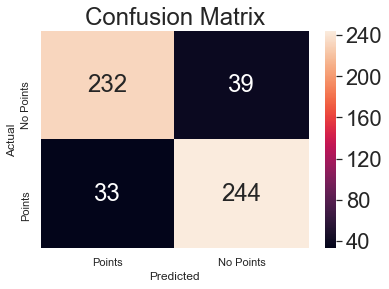

In [22]:
#Results for Logistic Regression
print('Results for Logistic Regression:')
print('Prediction Accuracy:', accuracy_score(y_test, lr_y_predict))
print('Confusion Matrix: \n', confusion_matrix(y_test, lr_y_predict))
print('Classification Report: \n', classification_report(y_test, lr_y_predict))
conf_mat = confusion_matrix(y_test, lr_y_predict)
ax= plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

In [23]:
# Use Decision Tree Classifier
dtc_entropy_model=tree.DecisionTreeClassifier(criterion='entropy')
dtc_entropy_model.fit(X_train, y_train)
dtc_entropy_y_predict = dtc_entropy_model.predict(X_test)

Results for Decision Tree - Entropy:
Prediction Accuracy: 0.7718978102189781
Confusion Matrix: 
 [[198  73]
 [ 52 225]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.79      0.73      0.76       271
           P       0.76      0.81      0.78       277

   micro avg       0.77      0.77      0.77       548
   macro avg       0.77      0.77      0.77       548
weighted avg       0.77      0.77      0.77       548

Feature Importance: 
 [0.02450785 0.1598907  0.06019206 0.04991226 0.35606004 0.02464633
 0.05347167 0.07903005 0.02595428 0.05444464 0.         0.
 0.00179088 0.00423797 0.         0.         0.00182877 0.00125834
 0.00158475 0.         0.         0.         0.         0.
 0.         0.         0.00178145 0.         0.         0.
 0.00058659 0.00284425 0.00367064 0.         0.00309375 0.00455564
 0.         0.00351713 0.01307483 0.00536301 0.         0.00125834
 0.         0.         0.         0.0091688  0.01203579 0.009

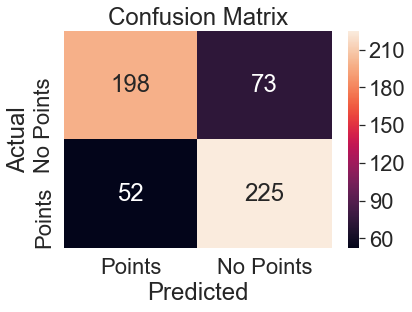

In [24]:
#Results for Decision Tree - Entropy
print('Results for Decision Tree - Entropy:')
print('Prediction Accuracy:', accuracy_score(y_test, dtc_entropy_y_predict))
print('Confusion Matrix: \n', confusion_matrix(y_test, dtc_entropy_y_predict))
print('Classification Report: \n', classification_report(y_test, dtc_entropy_y_predict))
print('Feature Importance: \n', dtc_entropy_model.feature_importances_)
conf_mat = confusion_matrix(y_test, dtc_entropy_y_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

In [25]:
# Decsion Tree Classifier - Gini
dtc_gini_model = tree.DecisionTreeClassifier(criterion='gini')
dtc_gini_model.fit(X_train, y_train)
dtc_gini_y_predict = dtc_gini_model.predict(X_test)

Results for Decision Tree - Gini:
Prediction Accuracy: 0.7755474452554745
Confusion Matrix: 
 [[203  68]
 [ 55 222]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.79      0.75      0.77       271
           P       0.77      0.80      0.78       277

   micro avg       0.78      0.78      0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

Feature Importance: 
 [0.0376463  0.15117264 0.05260689 0.04142385 0.41597871 0.01421213
 0.05459548 0.04965908 0.02768543 0.04266613 0.         0.00134555
 0.00173159 0.00643108 0.         0.00372322 0.         0.00332109
 0.00099492 0.00309819 0.         0.         0.00137047 0.
 0.00152274 0.00160219 0.         0.         0.         0.00136882
 0.00230953 0.00097455 0.00266063 0.         0.         0.00581931
 0.         0.00519874 0.01123749 0.00530245 0.         0.00121819
 0.         0.         0.         0.00720699 0.0

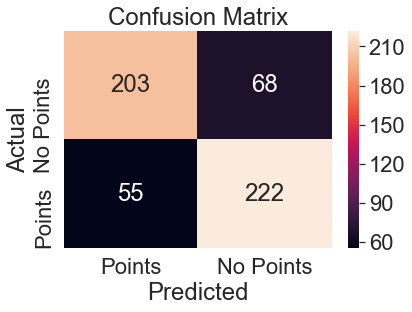

In [26]:
# Results for Decision Tree Classifier - Gini
print('Results for Decision Tree - Gini:')
print('Prediction Accuracy:', accuracy_score(y_test, dtc_gini_y_predict))
print('Confusion Matrix: \n', confusion_matrix(y_test, dtc_gini_y_predict))
print('Classification Report: \n', classification_report(y_test, dtc_gini_y_predict))
print('Feature Importance: \n', dtc_gini_model.feature_importances_)
conf_mat = confusion_matrix(y_test, dtc_gini_y_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

In [27]:
# Using Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_y_predict = nb_model.predict(X_test)

Results for Naive Bayes:
Prediction Accuracy: 0.6697080291970803
Confusion Matrix: 
 [[ 99 172]
 [  9 268]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.92      0.37      0.52       271
           P       0.61      0.97      0.75       277

   micro avg       0.67      0.67      0.67       548
   macro avg       0.76      0.67      0.63       548
weighted avg       0.76      0.67      0.64       548



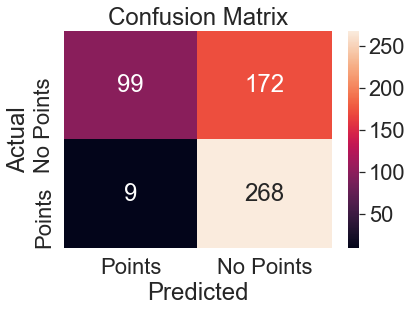

In [28]:
# Results for Naive Bayes Model Prediction
print('Results for Naive Bayes:')
print('Prediction Accuracy:', accuracy_score(y_test, nb_y_predict))
print('Confusion Matrix: \n', confusion_matrix(y_test, nb_y_predict))
print('Classification Report: \n', classification_report(y_test, nb_y_predict))
conf_mat = confusion_matrix(y_test, nb_y_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

In [29]:
# Using MLP Classifier
#mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
mlp_model.fit(X_train, y_train)
mlp_y_predict = mlp_model.predict(X_test)

Iteration 1, loss = 4.62573014
Iteration 2, loss = 0.61924762
Iteration 3, loss = 0.62705024
Iteration 4, loss = 0.59007165
Iteration 5, loss = 0.47897696
Iteration 6, loss = 0.45713516
Iteration 7, loss = 0.43728492
Iteration 8, loss = 0.43385243
Iteration 9, loss = 0.49374137
Iteration 10, loss = 0.42223900
Iteration 11, loss = 0.44436419
Iteration 12, loss = 0.42528947
Iteration 13, loss = 0.42632325
Iteration 14, loss = 0.41941511
Iteration 15, loss = 0.43104767
Iteration 16, loss = 0.41049996
Iteration 17, loss = 0.40748551
Iteration 18, loss = 0.42671981
Iteration 19, loss = 0.41231543
Iteration 20, loss = 0.40391992
Iteration 21, loss = 0.41223455
Iteration 22, loss = 0.42505451
Iteration 23, loss = 0.40541172
Iteration 24, loss = 0.43109202
Iteration 25, loss = 0.40556489
Iteration 26, loss = 0.40604955
Iteration 27, loss = 0.41190519
Iteration 28, loss = 0.39895662
Iteration 29, loss = 0.41544695
Iteration 30, loss = 0.40188175
Iteration 31, loss = 0.41256793
Iteration 32, los

Results for MLP:
Prediction Accuracy: 0.8156934306569343
Confusion Matrix: 
 [[233  38]
 [ 63 214]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.79      0.86      0.82       271
           P       0.85      0.77      0.81       277

   micro avg       0.82      0.82      0.82       548
   macro avg       0.82      0.82      0.82       548
weighted avg       0.82      0.82      0.82       548



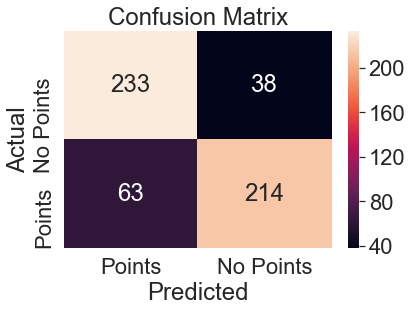

In [30]:
# Results for MLP Classifier - Neural Network
print('Results for MLP:')
print('Prediction Accuracy:', accuracy_score(y_test, mlp_y_predict))
print('Confusion Matrix: \n', confusion_matrix(y_test, mlp_y_predict))
print('Classification Report: \n', classification_report(y_test, mlp_y_predict))
conf_mat = confusion_matrix(y_test, mlp_y_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

In [31]:
#Run 2 - Remove Constructor and Add Driver into Features
results_logr_dummy2 = pd.get_dummies(results_logr, columns = ['Circuit', 'Driver', 'Weather'])

In [32]:
results_logr_dummy2.head()

,GridStart,TotalLaps,FastestLapTime,FastestLapSpeed,Constructor,QualifyPos,NumPitStops,LastPitStopLap,PitStopTime,SaftetyCarLaps,...,Driver_sutil,Driver_trulli,Driver_vandoorne,Driver_vergne,Driver_vettel,Driver_webber,Driver_wehrlein,Weather_Dry,Weather_Varied,Weather_Wet
0,2,58,90.3,211.382,mclaren,2,2,36,23.199,0,...,0,0,0,0,0,0,0,1,0,0
1,4,58,89.9,212.396,mclaren,4,3,37,22.681,0,...,0,0,0,0,0,0,0,1,0,0
2,17,48,91.4,208.861,williams,17,4,40,26.309,0,...,0,0,0,0,0,0,0,1,0,0
3,18,57,92.4,206.661,renault,18,2,30,25.098,0,...,0,0,0,0,0,0,0,1,0,0
4,6,58,90.1,211.969,renault,6,2,36,25.683,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
features2 = list(results_logr_dummy2)
features2.remove('Constructor')
features2.remove('PointsFinish')
X2 = results_logr_dummy2[features2]
y2 = results_logr_dummy2['PointsFinish']

In [34]:
features2

['GridStart',
 'TotalLaps',
 'FastestLapTime',
 'FastestLapSpeed',
 'QualifyPos',
 'NumPitStops',
 'LastPitStopLap',
 'PitStopTime',
 'SaftetyCarLaps',
 'DriverAge',
 'Circuit_BAK',
 'Circuit_albert_park',
 'Circuit_americas',
 'Circuit_bahrain',
 'Circuit_buddh',
 'Circuit_catalunya',
 'Circuit_hockenheimring',
 'Circuit_hungaroring',
 'Circuit_interlagos',
 'Circuit_istanbul',
 'Circuit_marina_bay',
 'Circuit_monaco',
 'Circuit_monza',
 'Circuit_nurburgring',
 'Circuit_red_bull_ring',
 'Circuit_rodriguez',
 'Circuit_sepang',
 'Circuit_shanghai',
 'Circuit_silverstone',
 'Circuit_sochi',
 'Circuit_spa',
 'Circuit_suzuka',
 'Circuit_valencia',
 'Circuit_villeneuve',
 'Circuit_yas_marina',
 'Circuit_yeongam',
 'Driver_alguersuari',
 'Driver_alonso',
 'Driver_ambrosio',
 'Driver_barrichello',
 'Driver_bottas',
 'Driver_brendon_hartley',
 'Driver_bruno_senna',
 'Driver_buemi',
 'Driver_button',
 'Driver_chandhok',
 'Driver_chilton',
 'Driver_ericsson',
 'Driver_garde',
 'Driver_gasly',
 '

In [35]:
#Split the Sample as 80% training, 20% test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [36]:
# Feature Selection Using Recursive Feature Selection
fit_lr_model = LogisticRegression(solver='liblinear')#solver='lbfgs', max_iter=10000)
rfe = RFE(fit_lr_model, 3)
fit_lr = rfe.fit(X2,y2)
print("Num Features: %s" % (fit_lr.n_features_))
print("Selected Features: %s" % (fit_lr.support_))
print("Feature Ranking: %s" % (fit_lr.ranking_))

Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False  True False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False]
Feature Ranking: [55 81 88 90 89 60 91 93 87 84 48 47 73 76 64 63 77 71 58 62 66 65 80 92
 61 67 59 70 72 69 52 74 82 78 79 75 46 24 11 31 25 38 44 43 26 85  3  7
 10 32 45  2 40  1  8 18 35 28 15  6  5 68 53  1 83 14 34 23 22 17 57 36
 29 27 37  1 19 41 30  9 21 33 39 13 51 86 12 42 56  4 20 16 49 50 54]


Results for Logistic Regression:
Prediction Accuracy: 0.8576642335766423
Confusion Matrix: 
 [[229  42]
 [ 36 241]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.86      0.85      0.85       271
           P       0.85      0.87      0.86       277

   micro avg       0.86      0.86      0.86       548
   macro avg       0.86      0.86      0.86       548
weighted avg       0.86      0.86      0.86       548



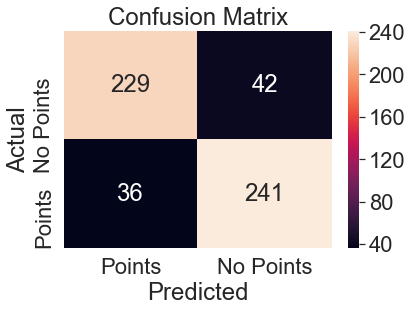

In [37]:
# Use Logistic Regression - using Default Solver and LBfgs with 7000 iteration (no convergence 6000 and below)
#lr_model=LogisticRegression()
lr_model=LogisticRegression(solver='lbfgs', max_iter=7000)
lr_model.fit(X2_train, y2_train)
lr_y2_predict = lr_model.predict(X2_test)
#Results for Logistic Regression
print('Results for Logistic Regression:')
print('Prediction Accuracy:', accuracy_score(y2_test, lr_y2_predict))
print('Confusion Matrix: \n', confusion_matrix(y2_test, lr_y2_predict))
print('Classification Report: \n', classification_report(y2_test, lr_y2_predict))
conf_mat = confusion_matrix(y2_test, lr_y2_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Decision Tree - Entropy:
Prediction Accuracy: 0.7755474452554745
Confusion Matrix: 
 [[205  66]
 [ 57 220]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.78      0.76      0.77       271
           P       0.77      0.79      0.78       277

   micro avg       0.78      0.78      0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

Feature Importance: 
 [0.02081004 0.15170915 0.05430463 0.06433786 0.36430198 0.0181328
 0.04692437 0.07036266 0.0252628  0.03936546 0.         0.00411747
 0.00100053 0.004293   0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0032446  0.         0.         0.00118828 0.00125834 0.
 0.         0.00328082 0.00173576 0.0011787  0.0029324  0.
 0.00183968 0.00408163 0.         0.         0.00349017 0.
 0.00153574 0.00088387 0.00714689 0.         0.         0.00328746
 0.        

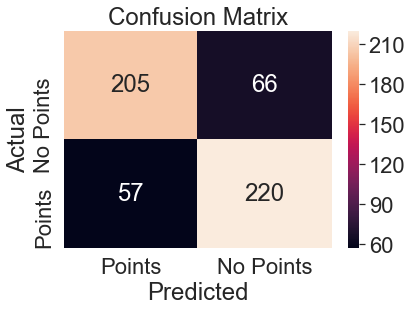

In [38]:
# Use Decision Tree Classifier
dtc_entropy_model=tree.DecisionTreeClassifier(criterion='entropy')
dtc_entropy_model.fit(X2_train, y2_train)
dtc_entropy_y2_predict = dtc_entropy_model.predict(X2_test)
#Results for Decision Tree - Entropy
print('Results for Decision Tree - Entropy:')
print('Prediction Accuracy:', accuracy_score(y2_test, dtc_entropy_y2_predict))
print('Confusion Matrix: \n', confusion_matrix(y2_test, dtc_entropy_y2_predict))
print('Classification Report: \n', classification_report(y2_test, dtc_entropy_y2_predict))
print('Feature Importance: \n', dtc_entropy_model.feature_importances_)
conf_mat = confusion_matrix(y2_test, dtc_entropy_y2_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Decision Tree - Gini:
Prediction Accuracy: 0.7554744525547445
Confusion Matrix: 
 [[194  77]
 [ 57 220]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.77      0.72      0.74       271
           P       0.74      0.79      0.77       277

   micro avg       0.76      0.76      0.76       548
   macro avg       0.76      0.76      0.75       548
weighted avg       0.76      0.76      0.76       548

Feature Importance: 
 [3.28092663e-02 1.49706834e-01 6.05999807e-02 5.07365852e-02
 3.98742959e-01 1.12599456e-02 4.42653600e-02 6.68013995e-02
 1.89728833e-02 3.78025987e-02 0.00000000e+00 3.88679854e-03
 1.21819347e-03 4.83023750e-03 1.25441003e-03 2.73043364e-04
 0.00000000e+00 5.53414061e-03 1.49585308e-03 1.35754354e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.30286705e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.66396154e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.13645102e-04
 1.73111704e-03 9.136

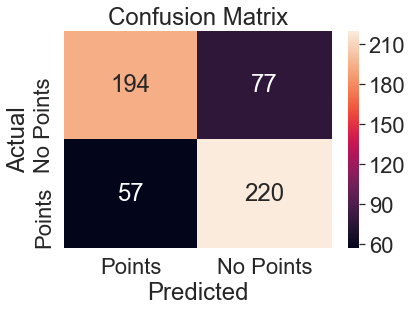

In [39]:
# Decsion Tree Classifier - Gini
dtc_gini_model = tree.DecisionTreeClassifier(criterion='gini')
dtc_gini_model.fit(X2_train, y2_train)
dtc_gini_y2_predict = dtc_gini_model.predict(X2_test)
# Results for Decision Tree Classifier - Gini
print('Results for Decision Tree - Gini:')
print('Prediction Accuracy:', accuracy_score(y2_test, dtc_gini_y2_predict))
print('Confusion Matrix: \n', confusion_matrix(y2_test, dtc_gini_y2_predict))
print('Classification Report: \n', classification_report(y2_test, dtc_gini_y2_predict))
print('Feature Importance: \n', dtc_gini_model.feature_importances_)
conf_mat = confusion_matrix(y2_test, dtc_gini_y2_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Naive Bayes:
Prediction Accuracy: 0.7135036496350365
Confusion Matrix: 
 [[122 149]
 [  8 269]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.94      0.45      0.61       271
           P       0.64      0.97      0.77       277

   micro avg       0.71      0.71      0.71       548
   macro avg       0.79      0.71      0.69       548
weighted avg       0.79      0.71      0.69       548



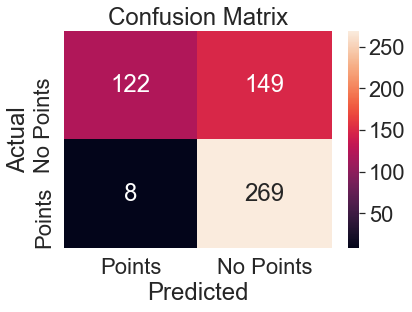

In [40]:
# Using Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X2_train, y2_train)
nb_y2_predict = nb_model.predict(X2_test)
# Results for Naive Bayes Model Prediction
print('Results for Naive Bayes:')
print('Prediction Accuracy:', accuracy_score(y2_test, nb_y2_predict))
print('Confusion Matrix: \n', confusion_matrix(y2_test, nb_y2_predict))
print('Classification Report: \n', classification_report(y2_test, nb_y2_predict))
conf_mat = confusion_matrix(y2_test, nb_y2_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Iteration 1, loss = 2.90764277
Iteration 2, loss = 0.56117877
Iteration 3, loss = 0.49327480
Iteration 4, loss = 0.47626133
Iteration 5, loss = 0.46406356
Iteration 6, loss = 0.48155355
Iteration 7, loss = 0.51790282
Iteration 8, loss = 0.42159811
Iteration 9, loss = 0.43992304
Iteration 10, loss = 0.42613389
Iteration 11, loss = 0.47240935
Iteration 12, loss = 0.45958681
Iteration 13, loss = 0.41588273
Iteration 14, loss = 0.41350857
Iteration 15, loss = 0.42119925
Iteration 16, loss = 0.41719877
Iteration 17, loss = 0.41624604
Iteration 18, loss = 0.41343501
Iteration 19, loss = 0.41976961
Iteration 20, loss = 0.40242856
Iteration 21, loss = 0.40959956
Iteration 22, loss = 0.42201927
Iteration 23, loss = 0.41203848
Iteration 24, loss = 0.42094608
Iteration 25, loss = 0.41793853
Iteration 26, loss = 0.41858257
Iteration 27, loss = 0.41455318
Iteration 28, loss = 0.41760909
Iteration 29, loss = 0.40754125
Iteration 30, loss = 0.41397367
Iteration 31, loss = 0.43757127
Training loss did

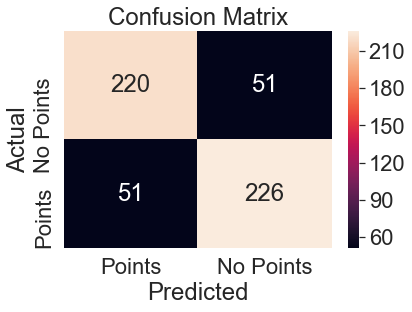

In [41]:
# Using MLP Classifier
#mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
mlp_model.fit(X2_train, y2_train)
mlp_y2_predict = mlp_model.predict(X2_test)
# Results for MLP Classifier - Neural Network
print('Results for MLP:')
print('Prediction Accuracy:', accuracy_score(y2_test, mlp_y2_predict))
print('Confusion Matrix: \n', confusion_matrix(y2_test, mlp_y2_predict))
print('Classification Report: \n', classification_report(y2_test, mlp_y2_predict))
conf_mat = confusion_matrix(y2_test, mlp_y2_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

In [42]:
#Run 3 -  Remove Constructor and Driver from Features
results_logr_dummy3 = pd.get_dummies(results_logr, columns = (['Circuit', 'Weather']))
results_logr_dummy3.head()

,GridStart,TotalLaps,FastestLapTime,FastestLapSpeed,Driver,Constructor,QualifyPos,NumPitStops,LastPitStopLap,PitStopTime,...,Circuit_sochi,Circuit_spa,Circuit_suzuka,Circuit_valencia,Circuit_villeneuve,Circuit_yas_marina,Circuit_yeongam,Weather_Dry,Weather_Varied,Weather_Wet
0,2,58,90.3,211.382,hamilton,mclaren,2,2,36,23.199,...,0,0,0,0,0,0,0,1,0,0
1,4,58,89.9,212.396,button,mclaren,4,3,37,22.681,...,0,0,0,0,0,0,0,1,0,0
2,17,48,91.4,208.861,barrichello,williams,17,4,40,26.309,...,0,0,0,0,0,0,0,1,0,0
3,18,57,92.4,206.661,heidfeld,renault,18,2,30,25.098,...,0,0,0,0,0,0,0,1,0,0
4,6,58,90.1,211.969,petrov,renault,6,2,36,25.683,...,0,0,0,0,0,0,0,1,0,0


In [43]:
features3 = list(results_logr_dummy3)
features3.remove('Driver')
features3.remove('Constructor')
features3.remove('PointsFinish')
X3 = results_logr_dummy3[features3]
y3 = results_logr_dummy3['PointsFinish']
features3

['GridStart',
 'TotalLaps',
 'FastestLapTime',
 'FastestLapSpeed',
 'QualifyPos',
 'NumPitStops',
 'LastPitStopLap',
 'PitStopTime',
 'SaftetyCarLaps',
 'DriverAge',
 'Circuit_BAK',
 'Circuit_albert_park',
 'Circuit_americas',
 'Circuit_bahrain',
 'Circuit_buddh',
 'Circuit_catalunya',
 'Circuit_hockenheimring',
 'Circuit_hungaroring',
 'Circuit_interlagos',
 'Circuit_istanbul',
 'Circuit_marina_bay',
 'Circuit_monaco',
 'Circuit_monza',
 'Circuit_nurburgring',
 'Circuit_red_bull_ring',
 'Circuit_rodriguez',
 'Circuit_sepang',
 'Circuit_shanghai',
 'Circuit_silverstone',
 'Circuit_sochi',
 'Circuit_spa',
 'Circuit_suzuka',
 'Circuit_valencia',
 'Circuit_villeneuve',
 'Circuit_yas_marina',
 'Circuit_yeongam',
 'Weather_Dry',
 'Weather_Varied',
 'Weather_Wet']

In [44]:
#Split the Sample as 80% training, 20% test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [45]:
# Feature Selection Using Recursive Feature Selection
fit_lr_model = LogisticRegression(solver='lbfgs', max_iter=8000) #solver='liblinear')#
rfe = RFE(fit_lr_model, 3)
fit_lr = rfe.fit(X3,y3)
print("Num Features: %s" % (fit_lr.n_features_))
print("Selected Features: %s" % (fit_lr.support_))
print("Feature Ranking: %s" % (fit_lr.ranking_))

Num Features: 3
Selected Features: [ True False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True]
Feature Ranking: [ 1 16 21 23 34  5 36 37 35 32  2  1 29 19 30  8 15 12  7 26 17  4 14 24
 10  6 25 22 31 28  3 11 27 13 18 33  9 20  1]


Results for Logistic Regression:
Prediction Accuracy: 0.8467153284671532
Confusion Matrix: 
 [[229  42]
 [ 42 235]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.85      0.85      0.85       271
           P       0.85      0.85      0.85       277

   micro avg       0.85      0.85      0.85       548
   macro avg       0.85      0.85      0.85       548
weighted avg       0.85      0.85      0.85       548



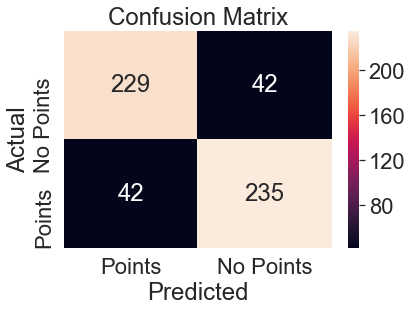

In [46]:
# Use Logistic Regression - using Default Solver and LBfgs with 7000 iteration (no convergence 6000 and below)
#lr_model=LogisticRegression()
lr_model=LogisticRegression(solver='lbfgs', max_iter=9000)
lr_model.fit(X3_train, y3_train)
lr_y3_predict = lr_model.predict(X3_test)
#Results for Logistic Regression
print('Results for Logistic Regression:')
print('Prediction Accuracy:', accuracy_score(y3_test, lr_y3_predict))
print('Confusion Matrix: \n', confusion_matrix(y3_test, lr_y3_predict))
print('Classification Report: \n', classification_report(y3_test, lr_y3_predict))
conf_mat = confusion_matrix(y3_test, lr_y3_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Decision Tree - Entropy:
Prediction Accuracy: 0.7609489051094891
Confusion Matrix: 
 [[196  75]
 [ 56 221]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.78      0.72      0.75       271
           P       0.75      0.80      0.77       277

   micro avg       0.76      0.76      0.76       548
   macro avg       0.76      0.76      0.76       548
weighted avg       0.76      0.76      0.76       548

Feature Importance: 
 [0.02485315 0.16110519 0.0829467  0.07433087 0.34827209 0.02897451
 0.0598695  0.08774463 0.01944857 0.06239083 0.         0.
 0.00595452 0.00439429 0.         0.00349426 0.         0.
 0.003571   0.         0.         0.         0.00206884 0.
 0.         0.         0.         0.00588618 0.00125834 0.
 0.00178145 0.00249503 0.00367064 0.00148226 0.00157191 0.00242104
 0.00399619 0.00601801 0.        ]


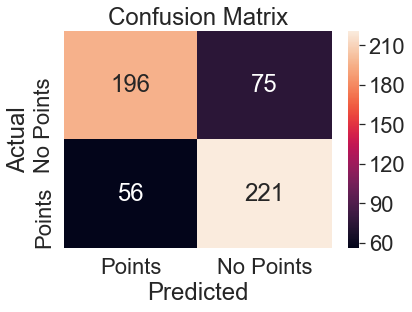

In [47]:
# Use Decision Tree Classifier
dtc_entropy_model=tree.DecisionTreeClassifier(criterion='entropy')
dtc_entropy_model.fit(X3_train, y3_train)
dtc_entropy_y3_predict = dtc_entropy_model.predict(X3_test)
#Results for Decision Tree - Entropy
print('Results for Decision Tree - Entropy:')
print('Prediction Accuracy:', accuracy_score(y3_test, dtc_entropy_y3_predict))
print('Confusion Matrix: \n', confusion_matrix(y3_test, dtc_entropy_y3_predict))
print('Classification Report: \n', classification_report(y3_test, dtc_entropy_y3_predict))
print('Feature Importance: \n', dtc_entropy_model.feature_importances_)
conf_mat = confusion_matrix(y3_test, dtc_entropy_y3_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Decision Tree - Gini:
Prediction Accuracy: 0.7718978102189781
Confusion Matrix: 
 [[205  66]
 [ 59 218]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.78      0.76      0.77       271
           P       0.77      0.79      0.78       277

   micro avg       0.77      0.77      0.77       548
   macro avg       0.77      0.77      0.77       548
weighted avg       0.77      0.77      0.77       548

Feature Importance: 
 [2.25487017e-02 1.48039426e-01 7.93629546e-02 5.81711463e-02
 4.17177023e-01 2.38418275e-02 5.62597362e-02 6.67728650e-02
 2.71193563e-02 5.05965402e-02 9.13645102e-04 3.06840667e-03
 4.21281245e-03 6.01134740e-03 0.00000000e+00 3.00325436e-03
 0.00000000e+00 3.32108915e-03 8.52914049e-04 1.34555006e-03
 9.39340054e-05 1.37046765e-03 3.01249093e-03 0.00000000e+00
 0.00000000e+00 1.36062840e-03 9.28325129e-04 4.17910235e-03
 5.36005126e-04 4.93207861e-04 0.00000000e+00 9.13645102e-04
 8.96350394e-04 0.000

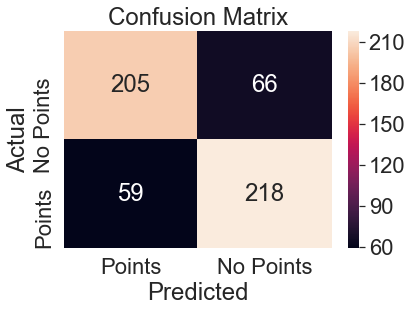

In [48]:
# Decsion Tree Classifier - Gini
dtc_gini_model = tree.DecisionTreeClassifier(criterion='gini')
dtc_gini_model.fit(X3_train, y3_train)
dtc_gini_y3_predict = dtc_gini_model.predict(X3_test)
# Results for Decision Tree Classifier - Gini
print('Results for Decision Tree - Gini:')
print('Prediction Accuracy:', accuracy_score(y3_test, dtc_gini_y3_predict))
print('Confusion Matrix: \n', confusion_matrix(y3_test, dtc_gini_y3_predict))
print('Classification Report: \n', classification_report(y3_test, dtc_gini_y3_predict))
print('Feature Importance: \n', dtc_gini_model.feature_importances_)
conf_mat = confusion_matrix(y3_test, dtc_gini_y3_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Naive Bayes:
Prediction Accuracy: 0.6934306569343066
Confusion Matrix: 
 [[194  77]
 [ 91 186]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.68      0.72      0.70       271
           P       0.71      0.67      0.69       277

   micro avg       0.69      0.69      0.69       548
   macro avg       0.69      0.69      0.69       548
weighted avg       0.69      0.69      0.69       548



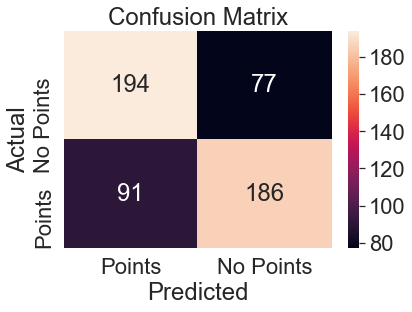

In [49]:
# Using Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X3_train, y3_train)
nb_y3_predict = nb_model.predict(X3_test)
# Results for Naive Bayes Model Prediction
print('Results for Naive Bayes:')
print('Prediction Accuracy:', accuracy_score(y3_test, nb_y3_predict))
print('Confusion Matrix: \n', confusion_matrix(y3_test, nb_y3_predict))
print('Classification Report: \n', classification_report(y3_test, nb_y3_predict))
conf_mat = confusion_matrix(y3_test, nb_y3_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Iteration 1, loss = 3.51095509
Iteration 2, loss = 0.72986376
Iteration 3, loss = 0.56140246
Iteration 4, loss = 0.49247827
Iteration 5, loss = 0.49144035
Iteration 6, loss = 0.52184996
Iteration 7, loss = 0.43420586
Iteration 8, loss = 0.43949710
Iteration 9, loss = 0.42637327
Iteration 10, loss = 0.41754375
Iteration 11, loss = 0.43182448
Iteration 12, loss = 0.41599433
Iteration 13, loss = 0.42488073
Iteration 14, loss = 0.41929261
Iteration 15, loss = 0.42338308
Iteration 16, loss = 0.41568590
Iteration 17, loss = 0.42609934
Iteration 18, loss = 0.42295691
Iteration 19, loss = 0.40859516
Iteration 20, loss = 0.40875021
Iteration 21, loss = 0.40740734
Iteration 22, loss = 0.41760299
Iteration 23, loss = 0.42175200
Iteration 24, loss = 0.40961495
Iteration 25, loss = 0.40269753
Iteration 26, loss = 0.40801617
Iteration 27, loss = 0.40022804
Iteration 28, loss = 0.40261555
Iteration 29, loss = 0.39877905
Iteration 30, loss = 0.38789623
Iteration 31, loss = 0.40128770
Iteration 32, los

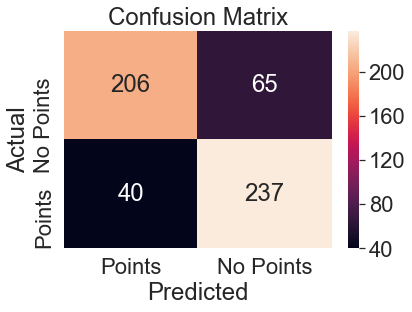

In [50]:
# Using MLP Classifier
#mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
mlp_model.fit(X3_train, y3_train)
mlp_y3_predict = mlp_model.predict(X3_test)
# Results for MLP Classifier - Neural Network
print('Results for MLP:')
print('Prediction Accuracy:', accuracy_score(y3_test, mlp_y3_predict))
print('Confusion Matrix: \n', confusion_matrix(y3_test, mlp_y3_predict))
print('Classification Report: \n', classification_report(y3_test, mlp_y3_predict))
conf_mat = confusion_matrix(y3_test, mlp_y3_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

In [51]:
#Run 3 -  Remove Constructor, Circuit & Driver from Features
results_logr_dummy4 = pd.get_dummies(results_logr, columns = (['Weather']))
results_logr_dummy4.head()

,GridStart,TotalLaps,FastestLapTime,FastestLapSpeed,Driver,Circuit,Constructor,QualifyPos,NumPitStops,LastPitStopLap,PitStopTime,SaftetyCarLaps,DriverAge,PointsFinish,Weather_Dry,Weather_Varied,Weather_Wet
0,2,58,90.3,211.382,hamilton,albert_park,mclaren,2,2,36,23.199,0,26,P,1,0,0
1,4,58,89.9,212.396,button,albert_park,mclaren,4,3,37,22.681,0,31,P,1,0,0
2,17,48,91.4,208.861,barrichello,albert_park,williams,17,4,40,26.309,0,38,N,1,0,0
3,18,57,92.4,206.661,heidfeld,albert_park,renault,18,2,30,25.098,0,33,N,1,0,0
4,6,58,90.1,211.969,petrov,albert_park,renault,6,2,36,25.683,0,26,P,1,0,0


In [52]:
features4 = list(results_logr_dummy4)
features4.remove('Driver')
features4.remove('Circuit')
features4.remove('Constructor')
features4.remove('PointsFinish')
X4 = results_logr_dummy4[features4]
y4 = results_logr_dummy4['PointsFinish']
features4

['GridStart',
 'TotalLaps',
 'FastestLapTime',
 'FastestLapSpeed',
 'QualifyPos',
 'NumPitStops',
 'LastPitStopLap',
 'PitStopTime',
 'SaftetyCarLaps',
 'DriverAge',
 'Weather_Dry',
 'Weather_Varied',
 'Weather_Wet']

In [53]:
#Split the Sample as 80% training, 20% test
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

In [54]:
# Feature Selection Using Recursive Feature Selection
fit_lr_model = LogisticRegression(solver='lbfgs', max_iter=3000) #solver='liblinear')#
rfe = RFE(fit_lr_model, 3)
fit_lr = rfe.fit(X4,y4)
print("Num Features: %s" % (fit_lr.n_features_))
print("Selected Features: %s" % (fit_lr.support_))
print("Feature Ranking: %s" % (fit_lr.ranking_))

Num Features: 3
Selected Features: [ True False False False False False False False False False False  True
  True]
Feature Ranking: [ 1  4  5  6  9  3 10 11  8  7  2  1  1]


Results for Logistic Regression:
Prediction Accuracy: 0.833941605839416
Confusion Matrix: 
 [[229  42]
 [ 49 228]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.82      0.85      0.83       271
           P       0.84      0.82      0.83       277

   micro avg       0.83      0.83      0.83       548
   macro avg       0.83      0.83      0.83       548
weighted avg       0.83      0.83      0.83       548



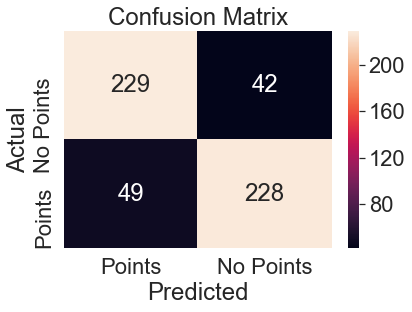

In [55]:
# Use Logistic Regression -
#lr_model=LogisticRegression()
lr_model=LogisticRegression(solver='lbfgs', max_iter=4000)
lr_model.fit(X4_train, y4_train)
lr_y4_predict = lr_model.predict(X4_test)
#Results for Logistic Regression
print('Results for Logistic Regression:')
print('Prediction Accuracy:', accuracy_score(y4_test, lr_y4_predict))
print('Confusion Matrix: \n', confusion_matrix(y4_test, lr_y4_predict))
print('Classification Report: \n', classification_report(y4_test, lr_y4_predict))
conf_mat = confusion_matrix(y4_test, lr_y4_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Decision Tree - Entropy:
Prediction Accuracy: 0.7572992700729927
Confusion Matrix: 
 [[197  74]
 [ 59 218]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.77      0.73      0.75       271
           P       0.75      0.79      0.77       277

   micro avg       0.76      0.76      0.76       548
   macro avg       0.76      0.76      0.76       548
weighted avg       0.76      0.76      0.76       548

Feature Importance: 
 [0.01977923 0.16460169 0.09048711 0.07808043 0.35328754 0.02680595
 0.06537824 0.09717268 0.02719744 0.06424951 0.00399619 0.006089
 0.00287499]


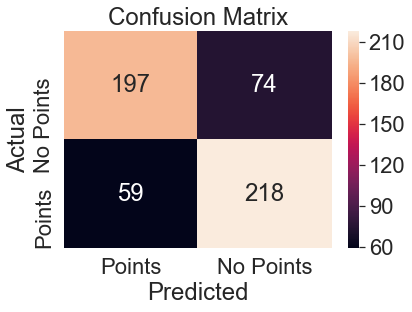

In [56]:
# Use Decision Tree Classifier
dtc_entropy_model=tree.DecisionTreeClassifier(criterion='entropy')
dtc_entropy_model.fit(X4_train, y4_train)
dtc_entropy_y4_predict = dtc_entropy_model.predict(X4_test)
#Results for Decision Tree - Entropy
print('Results for Decision Tree - Entropy:')
print('Prediction Accuracy:', accuracy_score(y4_test, dtc_entropy_y4_predict))
print('Confusion Matrix: \n', confusion_matrix(y4_test, dtc_entropy_y4_predict))
print('Classification Report: \n', classification_report(y4_test, dtc_entropy_y4_predict))
print('Feature Importance: \n', dtc_entropy_model.feature_importances_)
conf_mat = confusion_matrix(y4_test, dtc_entropy_y4_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Decision Tree - Gini:
Prediction Accuracy: 0.781021897810219
Confusion Matrix: 
 [[203  68]
 [ 52 225]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.80      0.75      0.77       271
           P       0.77      0.81      0.79       277

   micro avg       0.78      0.78      0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

Feature Importance: 
 [0.03217887 0.15691858 0.08682541 0.05515128 0.41190205 0.02244927
 0.0536417  0.08376245 0.02885894 0.05933511 0.         0.00616918
 0.00280715]


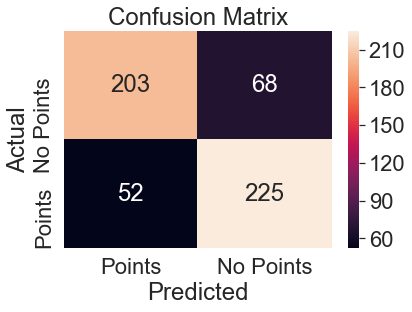

In [57]:
# Decsion Tree Classifier - Gini
dtc_gini_model = tree.DecisionTreeClassifier(criterion='gini')
dtc_gini_model.fit(X4_train, y4_train)
dtc_gini_y4_predict = dtc_gini_model.predict(X4_test)
# Results for Decision Tree Classifier - Gini
print('Results for Decision Tree - Gini:')
print('Prediction Accuracy:', accuracy_score(y4_test, dtc_gini_y4_predict))
print('Confusion Matrix: \n', confusion_matrix(y4_test, dtc_gini_y4_predict))
print('Classification Report: \n', classification_report(y4_test, dtc_gini_y4_predict))
print('Feature Importance: \n', dtc_gini_model.feature_importances_)
conf_mat = confusion_matrix(y4_test, dtc_gini_y4_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Naive Bayes:
Prediction Accuracy: 0.791970802919708
Confusion Matrix: 
 [[222  49]
 [ 65 212]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.77      0.82      0.80       271
           P       0.81      0.77      0.79       277

   micro avg       0.79      0.79      0.79       548
   macro avg       0.79      0.79      0.79       548
weighted avg       0.79      0.79      0.79       548



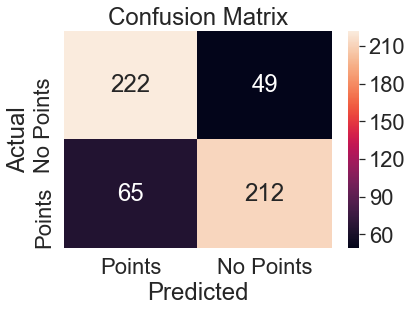

In [58]:
# Using Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X4_train, y4_train)
nb_y4_predict = nb_model.predict(X4_test)
# Results for Naive Bayes Model Prediction
print('Results for Naive Bayes:')
print('Prediction Accuracy:', accuracy_score(y4_test, nb_y4_predict))
print('Confusion Matrix: \n', confusion_matrix(y4_test, nb_y4_predict))
print('Classification Report: \n', classification_report(y4_test, nb_y4_predict))
conf_mat = confusion_matrix(y4_test, nb_y4_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Iteration 1, loss = 3.58039265
Iteration 2, loss = 0.66552401
Iteration 3, loss = 0.55956080
Iteration 4, loss = 0.49195364
Iteration 5, loss = 0.45973187
Iteration 6, loss = 0.51312855
Iteration 7, loss = 0.43505625
Iteration 8, loss = 0.41482490
Iteration 9, loss = 0.42116921
Iteration 10, loss = 0.42432087
Iteration 11, loss = 0.42527284
Iteration 12, loss = 0.43195500
Iteration 13, loss = 0.41392368
Iteration 14, loss = 0.41369665
Iteration 15, loss = 0.42597621
Iteration 16, loss = 0.41383913
Iteration 17, loss = 0.41654640
Iteration 18, loss = 0.42857340
Iteration 19, loss = 0.42448657
Iteration 20, loss = 0.40035712
Iteration 21, loss = 0.40275478
Iteration 22, loss = 0.40409873
Iteration 23, loss = 0.39267289
Iteration 24, loss = 0.44056801
Iteration 25, loss = 0.42426480
Iteration 26, loss = 0.41701382
Iteration 27, loss = 0.41314868
Iteration 28, loss = 0.40844110
Iteration 29, loss = 0.40101170
Iteration 30, loss = 0.40483605
Iteration 31, loss = 0.39599493
Iteration 32, los

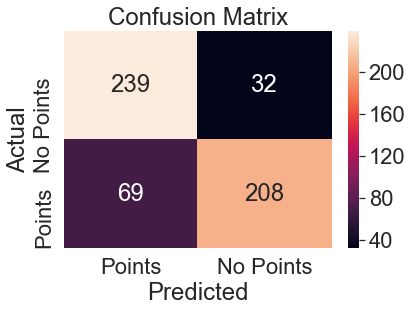

In [59]:
# Using MLP Classifier
#mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
mlp_model.fit(X4_train, y4_train)
mlp_y4_predict = mlp_model.predict(X4_test)
# Results for MLP Classifier - Neural Network
print('Results for MLP:')
print('Prediction Accuracy:', accuracy_score(y4_test, mlp_y4_predict))
print('Confusion Matrix: \n', confusion_matrix(y4_test, mlp_y4_predict))
print('Classification Report: \n', classification_report(y4_test, mlp_y4_predict))
conf_mat = confusion_matrix(y4_test, mlp_y4_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

In [60]:
#Run 5 -  Remove Constructor, Circuit, Driver, Weather from Features
results_logr_dummy5 = results_logr
results_logr_dummy5.head()

,GridStart,TotalLaps,FastestLapTime,FastestLapSpeed,Driver,Circuit,Constructor,QualifyPos,NumPitStops,LastPitStopLap,PitStopTime,Weather,SaftetyCarLaps,DriverAge,PointsFinish
0,2,58,90.3,211.382,hamilton,albert_park,mclaren,2,2,36,23.199,Dry,0,26,P
1,4,58,89.9,212.396,button,albert_park,mclaren,4,3,37,22.681,Dry,0,31,P
2,17,48,91.4,208.861,barrichello,albert_park,williams,17,4,40,26.309,Dry,0,38,N
3,18,57,92.4,206.661,heidfeld,albert_park,renault,18,2,30,25.098,Dry,0,33,N
4,6,58,90.1,211.969,petrov,albert_park,renault,6,2,36,25.683,Dry,0,26,P


In [61]:
features5 = list(results_logr_dummy5)
features5.remove('Driver')
features5.remove('Circuit')
features5.remove('Constructor')
features5.remove('Weather')
features5.remove('PointsFinish')
X5 = results_logr_dummy5[features5]
y5 = results_logr_dummy5['PointsFinish']
features5

['GridStart',
 'TotalLaps',
 'FastestLapTime',
 'FastestLapSpeed',
 'QualifyPos',
 'NumPitStops',
 'LastPitStopLap',
 'PitStopTime',
 'SaftetyCarLaps',
 'DriverAge']

In [62]:
#Split the Sample as 80% training, 20% test
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

In [63]:
# Feature Selection Using Recursive Feature Selection
fit_lr_model = LogisticRegression(solver='lbfgs', max_iter=1000) #solver='liblinear')#
rfe = RFE(fit_lr_model, 3)
fit_lr = rfe.fit(X5,y5)
print("Num Features: %s" % (fit_lr.n_features_))
print("Selected Features: %s" % (fit_lr.support_))
print("Feature Ranking: %s" % (fit_lr.ranking_))

Num Features: 3
Selected Features: [ True  True False False False  True False False False False]
Feature Ranking: [1 1 2 3 6 1 7 8 4 5]


Results for Logistic Regression:
Prediction Accuracy: 0.822992700729927
Confusion Matrix: 
 [[225  46]
 [ 51 226]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.82      0.83      0.82       271
           P       0.83      0.82      0.82       277

   micro avg       0.82      0.82      0.82       548
   macro avg       0.82      0.82      0.82       548
weighted avg       0.82      0.82      0.82       548



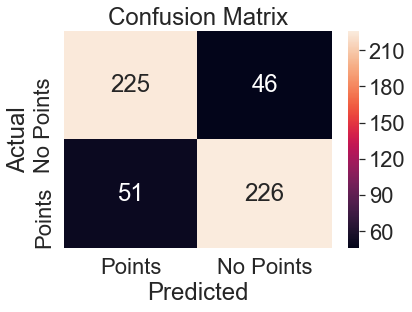

In [64]:
# Use Logistic Regression -
#lr_model=LogisticRegression()
lr_model=LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(X5_train, y5_train)
lr_y5_predict = lr_model.predict(X5_test)
#Results for Logistic Regression
print('Results for Logistic Regression:')
print('Prediction Accuracy:', accuracy_score(y5_test, lr_y5_predict))
print('Confusion Matrix: \n', confusion_matrix(y5_test, lr_y5_predict))
print('Classification Report: \n', classification_report(y5_test, lr_y5_predict))
conf_mat = confusion_matrix(y5_test, lr_y5_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Decision Tree - Entropy:
Prediction Accuracy: 0.7828467153284672
Confusion Matrix: 
 [[203  68]
 [ 51 226]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.80      0.75      0.77       271
           P       0.77      0.82      0.79       277

   micro avg       0.78      0.78      0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

Feature Importance: 
 [0.02564316 0.17458804 0.08489123 0.08185933 0.34944687 0.02728721
 0.06392634 0.10153521 0.02767093 0.06315168]


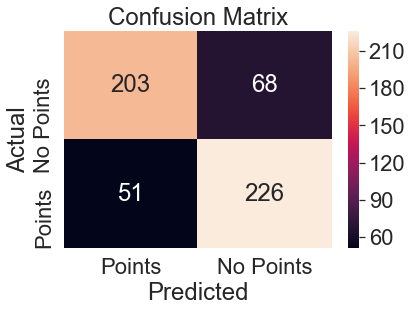

In [65]:
# Use Decision Tree Classifier
dtc_entropy_model=tree.DecisionTreeClassifier(criterion='entropy')
dtc_entropy_model.fit(X5_train, y5_train)
dtc_entropy_y5_predict = dtc_entropy_model.predict(X5_test)
#Results for Decision Tree - Entropy
print('Results for Decision Tree - Entropy:')
print('Prediction Accuracy:', accuracy_score(y5_test, dtc_entropy_y5_predict))
print('Confusion Matrix: \n', confusion_matrix(y5_test, dtc_entropy_y5_predict))
print('Classification Report: \n', classification_report(y5_test, dtc_entropy_y5_predict))
print('Feature Importance: \n', dtc_entropy_model.feature_importances_)
conf_mat = confusion_matrix(y5_test, dtc_entropy_y5_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Decision Tree - Gini:
Prediction Accuracy: 0.7755474452554745
Confusion Matrix: 
 [[200  71]
 [ 52 225]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.79      0.74      0.76       271
           P       0.76      0.81      0.79       277

   micro avg       0.78      0.78      0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

Feature Importance: 
 [0.02953194 0.15612857 0.09147633 0.06508757 0.41786435 0.0238155
 0.04218264 0.07244992 0.03462401 0.06683917]


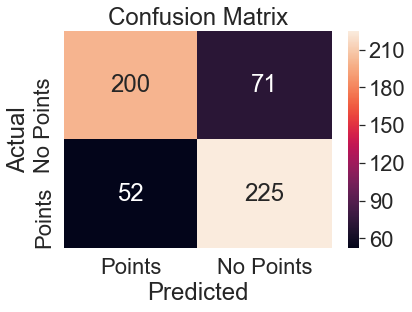

In [66]:
# Decsion Tree Classifier - Gini
dtc_gini_model = tree.DecisionTreeClassifier(criterion='gini')
dtc_gini_model.fit(X5_train, y5_train)
dtc_gini_y5_predict = dtc_gini_model.predict(X5_test)
# Results for Decision Tree Classifier - Gini
print('Results for Decision Tree - Gini:')
print('Prediction Accuracy:', accuracy_score(y5_test, dtc_gini_y5_predict))
print('Confusion Matrix: \n', confusion_matrix(y5_test, dtc_gini_y5_predict))
print('Classification Report: \n', classification_report(y5_test, dtc_gini_y5_predict))
print('Feature Importance: \n', dtc_gini_model.feature_importances_)
conf_mat = confusion_matrix(y5_test, dtc_gini_y5_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Results for Naive Bayes:
Prediction Accuracy: 0.801094890510949
Confusion Matrix: 
 [[224  47]
 [ 62 215]]
Classification Report: 
               precision    recall  f1-score   support

           N       0.78      0.83      0.80       271
           P       0.82      0.78      0.80       277

   micro avg       0.80      0.80      0.80       548
   macro avg       0.80      0.80      0.80       548
weighted avg       0.80      0.80      0.80       548



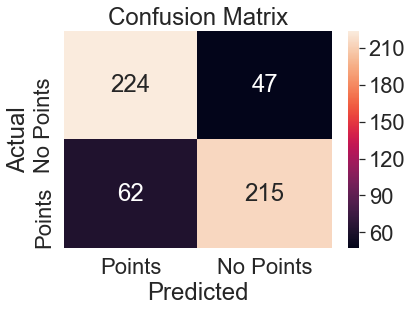

In [67]:
# Using Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X5_train, y5_train)
nb_y5_predict = nb_model.predict(X5_test)
# Results for Naive Bayes Model Prediction
print('Results for Naive Bayes:')
print('Prediction Accuracy:', accuracy_score(y5_test, nb_y5_predict))
print('Confusion Matrix: \n', confusion_matrix(y5_test, nb_y5_predict))
print('Classification Report: \n', classification_report(y5_test, nb_y5_predict))
conf_mat = confusion_matrix(y5_test, nb_y5_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);

Iteration 1, loss = 3.36643551
Iteration 2, loss = 0.62207037
Iteration 3, loss = 0.53656537
Iteration 4, loss = 0.47331316
Iteration 5, loss = 0.47729255
Iteration 6, loss = 0.46502839
Iteration 7, loss = 0.45073215
Iteration 8, loss = 0.43761318
Iteration 9, loss = 0.42635468
Iteration 10, loss = 0.42513613
Iteration 11, loss = 0.41145712
Iteration 12, loss = 0.41959211
Iteration 13, loss = 0.42216870
Iteration 14, loss = 0.43889704
Iteration 15, loss = 0.46833530
Iteration 16, loss = 0.41588930
Iteration 17, loss = 0.41172717
Iteration 18, loss = 0.42027981
Iteration 19, loss = 0.42786270
Iteration 20, loss = 0.42070519
Iteration 21, loss = 0.41005638
Iteration 22, loss = 0.41636443
Iteration 23, loss = 0.40969402
Iteration 24, loss = 0.41070730
Iteration 25, loss = 0.41417453
Iteration 26, loss = 0.41617808
Iteration 27, loss = 0.41696600
Iteration 28, loss = 0.41763863
Iteration 29, loss = 0.40978353
Iteration 30, loss = 0.40489682
Iteration 31, loss = 0.41161023
Iteration 32, los

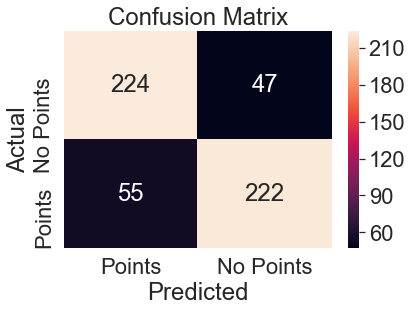

In [68]:
# Using MLP Classifier
#mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
mlp_model.fit(X5_train, y5_train)
mlp_y5_predict = mlp_model.predict(X5_test)
# Results for MLP Classifier - Neural Network
print('Results for MLP:')
print('Prediction Accuracy:', accuracy_score(y5_test, mlp_y5_predict))
print('Confusion Matrix: \n', confusion_matrix(y5_test, mlp_y5_predict))
print('Classification Report: \n', classification_report(y5_test, mlp_y5_predict))
conf_mat = confusion_matrix(y5_test, mlp_y5_predict)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g');
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Points', 'No Points']); ax.yaxis.set_ticklabels(['No Points', 'Points']);